# Import needed packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error as mae, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,Normalizer

from sklearn import svm

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import confusion_matrix
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder

# Data Preparation 

## dummy variable for categorical data

In [2]:
# read in and prepare X_train, y_train and X_test data
X_train=pd.read_csv('MLProjectData.csv')
X_test=pd.read_csv('testData.csv',index_col=0) # test data has index needed to remove

# get test data
y_train = X_train['target']
X_train.drop('target',axis=1,inplace=True)

# label to split the training and testing
X_train['train']=True
X_test['train']=False

temp=pd.get_dummies(X_train.append(X_test,sort=False))
X_train=temp[temp['train']==True].drop('train',axis=1)
X_test=temp[temp['train']==False].drop('train',axis=1)

# X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

## Standardize/Normalize
for non tree models such as SVR

In [5]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [29]:
X_test_norm = norm.transform(X_test)

In [87]:
X_t, X_v, y_t, y_v = train_test_split(X_train_std, y_train, test_size = 0.33, random_state = 42)

# Benchmark 

## median and mean

In [96]:
y_train.describe()

count    6350.000000
mean       20.035933
std         1.419549
min         8.479981
25%        19.453096
50%        20.062500
75%        20.680000
max        32.849998
Name: target, dtype: float64

In [117]:
y_mean=np.repeat(y_train.mean(), len(y_train))
y_median=np.repeat(y_train.median(), len(y_train))
print('Benchmark\nMean:\nR2:',r2_score(y_train, y_mean)) 
print('MAE:',mae(y_train, y_mean)) 
print('Median:\nR2:',r2_score(y_train, y_median)) 
print('MAE:',mae(y_train, y_median)) 

Benchmark
Mean:
R2: 1.1102230246251565e-16
MAE: 0.9567985025831722
Median:
R2: -0.0003503183503301699
MAE: 0.9563565006299212


## kernel density

In [91]:
y_train_array = y_train.values[:,np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y_train_array)
kde.score_samples(y_train_array)

print('MAE:',mae(y_train_array,kde.sample(len(y_train_array)))) 

MAE: 1.4492191158844947


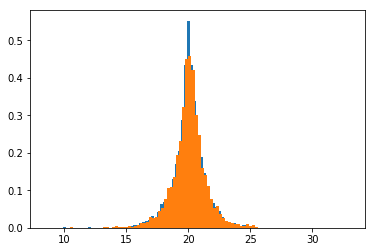

In [94]:
# Visualize the target
plt.hist(y_train,bins=100,density=0.5);
# y_train.quantile(q=0.05)
# y_train.quantile(q=0.95)
plt.hist(kde.sample(len(y_train_array)),bins=100,density=0.5);

# SVR

In [116]:
svr = svm.SVR(gamma='auto')
svr.fit(X_t, y_t) 

print('Training MAE:',mae(y_t, svr.predict(X_t))) 
print('Validation MAE:',mae(y_v, svr.predict(X_v))) 

Training R2: 0.41922643518750385
Validation R2: 0.9512327140596165


## Grid Search

In [21]:
svr_grid = svm.SVR()

params_svr = {'C': [0.0001,0.001,0.005,0.1,0.3,0.5,1,3,5], 
              'gamma': [5,4,3,2,1.5,1,0.9,0.8,0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_train_norm, y_train)

# Print the MAE score
print('Training MAE:', mae(y_train, grid_svr.best_estimator_.predict(X_train_norm)))

Training MAE: 0.9555074017445552


In [16]:
scores = cross_val_score(grid_svr.best_estimator_, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98748141 -0.93029187 -1.00920325 -0.91268809 -0.89527034 -0.97402762
 -0.94695896 -0.99043937 -0.93956817 -0.97839978]
-0.9564328867734393


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.5,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
  
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.9565388236580195

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.9565388236580195

In [25]:
grid_svr.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
params_svr

{'C': [0.1, 0.3, 0.5, 0.8, 1, 2, 3],
 'gamma': [1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1],
 'kernel': ['rbf']}

In [60]:
svr_grid = svm.SVR()

params_svr = {'C': [1,3,3.5,4], 
              'gamma': [2,1.5,1,0.8, 0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_t, y_t)

# Print the r2 score
print('Training R2:',r2_score(y_t, grid_svr.best_estimator_.predict(X_t)))
print('Training R2:',r2_score(y_v, grid_svr.best_estimator_.predict(X_v))) 

# best model 1

# SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.9,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
# Training R2: 0.9090573555403174
# Training R2: -0.0013610386571483168

# SVR(C=3, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=2,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Training R2: 0.9090573555403174
Training R2: -0.0013610386571483168


In [61]:
grid_svr.best_estimator_

SVR(C=3, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=2,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [97]:
print(r2_score(y_t, grid_svr.best_estimator_.predict(X_t))) 
print(mae(y_t, grid_svr.best_estimator_.predict(X_t))) 

0.9090573555403174
0.1501724058306333


## Cross Validation

In [26]:
svr_validate = svm.SVR(C=0.001,degree=3,gamma=5,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98733513 -0.92959761 -1.00955025 -0.91225911 -0.89308978 -0.9735381
 -0.9459592  -0.98967521 -0.93943394 -0.97791398]
-0.9558352306195598


In [19]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9908526  -0.93328811 -1.0075597  -0.91038571 -0.88694411 -0.97235694
 -0.94409592 -0.99034215 -0.94005804 -0.97752778]
-0.9553411052541234


In [28]:
svr_final = svm.SVR(C=0.001,degree=3,gamma=6,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')
svr_final.fit(X_train_norm, y_train)
scores = mae(y_train, svr_final.predict(X_train_norm))
print(scores)
print(np.mean(scores))

0.9554826744307535
0.9554826744307535


In [30]:
result = svr_final.predict(X_test_norm)

(array([12., 31., 18.,  2.,  6.,  2.,  2.,  1.,  1.,  2.]),
 array([20.06090585, 20.06534632, 20.06978679, 20.07422726, 20.07866773,
        20.0831082 , 20.08754867, 20.09198914, 20.09642961, 20.10087008,
        20.10531055]),
 <a list of 10 Patch objects>)

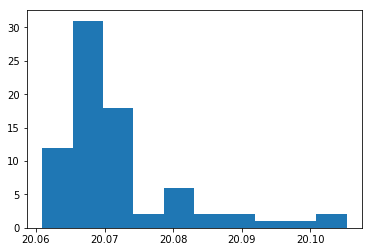

In [31]:
plt.hist(result)

In [32]:
len(result)

77

In [35]:
result.tofile('result.csv',sep='\n')

In [24]:
svr_validate = svm.SVR(C=0.001,degree=3,gamma=6,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=5, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.95842302 -0.96088885 -0.93335291 -0.96781927 -0.95877465]
-0.9558517380565034


In [118]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98802096 -0.93007319 -1.01014057 -0.91324138 -0.89532524 -0.97491872
 -0.94788529 -0.99105878 -0.9397429  -0.97827516]
-0.9568682186813454


### Standardized Data

In [6]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_std, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98771723 -0.93132544 -1.00851058 -0.9137543  -0.89537944 -0.97483196
 -0.94677773 -0.99193567 -0.9394993  -0.97780779]
-0.9567539434416366


In [7]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9908526  -0.93328811 -1.0075597  -0.91038571 -0.88694411 -0.97235694
 -0.94409592 -0.99034215 -0.94005804 -0.97752778]
-0.9553411052541234


## Normalized Data

In [154]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9908526  -0.93328811 -1.0075597  -0.91038571 -0.88694411 -0.97235694
 -0.94409592 -0.99034215 -0.94005804 -0.97752778]
-0.9553411052541234


## PCA + SVR

In [150]:
svr_grid = svm.SVR()

params_svr = {'C': [3,4,5,6,7,8], 
              'gamma': [5,4,3,2,1,0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_train_pca, y_train)

# Print the mae score
print('Training MAE:',mae(y_train, grid_svr.best_estimator_.predict(X_train_pca)))

Training MAE: 0.11878177387367138


In [151]:
grid_svr.best_estimator_

SVR(C=4, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=4,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [152]:
# Cross Validation
svr_validate = svm.SVR(C=4,degree=3,gamma=4,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_pca, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9878083  -0.93158894 -1.00834542 -0.9140054  -0.89540323 -0.97501114
 -0.94688645 -0.99214737 -0.93950996 -0.9777393 ]
-0.9568445504223


# xgboost

## Grid Search

In [ ]:
xgr = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
# xgr.fit(X_train, y_train)

# A parameter grid for XGBoost
# params = {'min_child_weight':[4,5],
#           'gamma':[i/10.0 for i in range(3,6)],
#           'subsample':[i/10.0 for i in range(6,11)],
#           'colsample_bytree':[i/10.0 for i in range(6,11)],
#           'max_depth': [2,3,4],
#           'gpu_id':[0],
#           'max_bin':[16],
#           'tree_method':['gpu_hist'],
#          'cv':[3]}

params = {'gpu_id':[0],
          'tree_method':['gpu_exact'],
          'n_estimators':[10,30,50,100,300,500,1000,2000,3000],
          'learning_rate':[0.001,0.01,0.03, 0.05,0.08, 0.1,0.3,0.5,0.7],
          'max_depth':[2,3,4]
         }


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

# Print the r2 score
print(r2_score(y_train, grid.best_estimator_.predict(X_train))) 

# Save the file
# y_test = grid.best_estimator_.predict(x_test)
# results_df = pd.DataFrame(data={'y':y_test}) 
# ids = test_df["ID"]
# joined = pd.DataFrame(ids).join(results_df)
# joined.to_csv("mercedes.csv", index=False)

In [43]:
print(r2_score(y_train, grid.best_estimator_.predict(X_train))) 

0.10545506348483091


In [45]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')

Best Estimator 1

r2_score: 0.10044651984945663

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, cv=3, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.05, max_bin=16, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')
       

{'cv': 3,
 'gpu_id': 0,
 'learning_rate': 0.05,
 'max_bin': 16,
 'max_depth': 2,
 'n_estimators': 100,
 'tree_method': 'gpu_exact'}

Best Estimator 2

0.10545506348483091

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')
       
       
{'gpu_id': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'tree_method': 'gpu_exact'}

In [46]:
grid.best_params_

{'gpu_id': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'tree_method': 'gpu_exact'}

In [120]:
xgr = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)

xgr.fit(X_t,y_t)
print('Training MAE:',mae(y_t, xgr.predict(X_t)))
print('Validation MAE:',mae(y_v, xgr.predict(X_v))) 

Training MAE: 0.9345158588903575
Validation MAE: 0.9707110896939656


In [122]:
importance = xgr.feature_importances_

In [124]:
np.mean(importance)

0.01

In [ ]:
col_important = (X_train.columns)[importance>0]

In [142]:
col_important

Index(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9',
       'num11', 'num13', 'num16', 'num17', 'num18', 'num19', 'num21', 'num22',
       'num24', 'num25', 'num27', 'num28', 'num32', 'num33', 'num34', 'num35',
       'num36', 'num40', 'num42', 'num44', 'num45', 'num46', 'num48', 'num49',
       'num58'],
      dtype='object')

In [144]:
X_train_imp = X_train[col_important]

## Cross Validation

In [3]:
xgr_cv = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)
# xgr_cv = XGBRegressor()


scores = cross_val_score(xgr_cv, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')

print(scores)
print(np.mean(scores))

[-0.99393415 -0.95350287 -1.02278295 -0.92854782 -0.91686269 -0.97663684
 -0.9515225  -1.01581628 -0.94676996 -0.98056586]
-0.9686941919682732


## CV on important variables

In [149]:
xgr_cv = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)
# xgr_cv = XGBRegressor()


scores = cross_val_score(xgr_cv, X_train_imp, y_train, cv=10, scoring = 'neg_mean_absolute_error',verbose=True, n_jobs=-1)

print(scores)
print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.2s remaining:   10.1s


[-0.99212601 -0.95100112 -1.02246828 -0.92710184 -0.92045212 -0.97497059
 -0.95330923 -1.01189952 -0.94613795 -0.97986577]
-0.9679332436821021


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.6s finished


In [123]:
xgr_cv = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)
# xgr_cv = XGBRegressor()


scores = cross_val_score(xgr_cv, X_train_pca, y_train, cv=10, scoring = 'neg_mean_absolute_error',verbose=True, n_jobs=-1)

print(scores)
print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.5s remaining:   10.3s


[-0.99203813 -0.94649947 -1.02849914 -0.92599416 -0.91176442 -0.98749017
 -0.95710285 -1.00019636 -0.95296927 -0.98677459]
-0.9689328565372017


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.9s finished


In [127]:
xgr_cv.fit(X_train_pca, y_train)
xgr_imp = xgr_cv.feature_importances_

In [140]:
pca_imp = (xgr_imp > 0.03).sum()

In [131]:
from scipy import stats

In [132]:
stats.describe(xgr_imp)

DescribeResult(nobs=30, minmax=(0.0, 0.10030564), mean=0.033333335, variance=0.00069777603, skewness=0.4285144805908203, kurtosis=-0.3627169177073939)

In [135]:
np.quantile(xgr_imp, 0.5)

0.03154599014669657

## Important Variables

In [ ]:
xgr

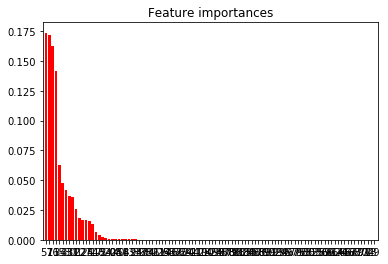

In [54]:
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## PCA + XGBOOST

### pca

In [109]:
pca = PCA()
pca.fit(X_train_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [114]:
# 35 components explain 80%
# 30 components explain 70%
pca.explained_variance_ratio_.cumsum()

array([0.19973459, 0.28608711, 0.33845086, 0.37747577, 0.41161975,
       0.44328948, 0.47426695, 0.4942322 , 0.50851313, 0.52201532,
       0.53516054, 0.54815198, 0.56093585, 0.57361734, 0.58568469,
       0.59761349, 0.6094022 , 0.62100833, 0.63230002, 0.64352079,
       0.65467183, 0.66577919, 0.67684759, 0.68785157, 0.69877087,
       0.70963107, 0.72042769, 0.73109764, 0.7417231 , 0.75217493,
       0.76236631, 0.77253448, 0.78266108, 0.79272615, 0.80261892,
       0.81233117, 0.82199633, 0.83156169, 0.84097757, 0.85034633,
       0.85960984, 0.86879495, 0.87777755, 0.88669537, 0.89547088,
       0.90411986, 0.9125614 , 0.92087645, 0.92896379, 0.93674581,
       0.94419843, 0.9511522 , 0.95803087, 0.96377787, 0.96935227,
       0.97332238, 0.9768065 , 0.98005521, 0.98287187, 0.98518175,
       0.987137  , 0.98898566, 0.99078581, 0.99217221, 0.99343772,
       0.99441006, 0.99522761, 0.99595371, 0.99656011, 0.99706276,
       0.9975608 , 0.99801221, 0.99840415, 0.99873552, 0.99903

In [122]:
pca_preprocess = PCA(n_components=30)
X_train_pca = pca_preprocess.fit_transform(X_train_std)
X_train_pca.shape

(6350, 30)

### xgboost grid search for pca

In [143]:
params = {'gpu_id':[0],
          'tree_method':['gpu_exact'],
          'n_estimators':[10,30,50,100,300,500,1000],
          'learning_rate':[0.001,0.01,0.03, 0.05],
          'max_depth':[2,3,4]
         }


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, scoring = 'neg_mean_absolute_error')
grid.fit(X_train_pca, y_train)

# Print the mae score
print(mae(y_train, grid.best_estimator_.predict(X_train_pca))) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9213248259763223


In [144]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.03, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')

### Cross Validation

In [145]:
xgr_cv = XGBRegressor(learning_rate=0.03, n_estimators=300, max_depth=2)
# xgr_cv = XGBRegressor()


scores = cross_val_score(xgr_cv, X_train_pca, y_train, cv=10, scoring = 'neg_mean_absolute_error')

print(scores)
print(np.mean(scores))

[-0.98708875 -0.93387311 -1.03079071 -0.91515681 -0.90118517 -0.97960081
 -0.94838646 -0.9867585  -0.94874606 -0.98640219]
-0.9617988573720281


# PLS

In [32]:
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

y_pred = pls.predict(X_train)
print('PLS R2:',r2_score(y_train, y_pred)) 

PLS R2: 0.0195066723727223


## Grid Search

In [11]:
params_pls = {'n_components':[1,2,3,4,5],
              'max_iter':[500,800,1000]
             }


# Initialize XGB and GridSearch
pls = PLSRegression()

grid = GridSearchCV(pls, params_pls, scoring= 'neg_mean_absolute_error')
grid.fit(X_train_std, y_train)

# Print the best mae
print(mae(y_train, grid.best_estimator_.predict(X_train))) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


5.775732726206678


In [12]:
grid.best_estimator_

PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

## Cross Validation

In [118]:
pls = PLSRegression(n_components=30)
# xgr_cv = XGBRegressor()


scores = cross_val_score(pls, X_train_std, y_train, cv=10, scoring = 'neg_mean_absolute_error')

print(scores)
print(np.mean(scores))

[-0.9930708  -0.95426301 -1.02642473 -0.92507169 -0.92384595 -0.97615114
 -0.96027011 -1.00234931 -0.96281832 -1.00815583]
-0.97324208940859


# NN

In [78]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [79]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    # a lot of layers!
    model.add(Dense(100, kernel_initializer='normal', activation='relu', input_shape=(n_cols,)))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

## initialize parameter

In [80]:
# Save the number of columns in predictors: n_cols
n_cols = X_train.shape[1]
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=1, verbose=0)

In [81]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train_std, y_train, cv=kfold)
print(results)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

[-1.24114492 -1.25556623 -1.25658758 -1.23670581 -1.15790705 -1.19048756
 -1.20610686 -1.26077091 -1.22591439 -1.20155494]
Results: -1.22 (0.03) MSE


In [99]:
# Set up the model: model
model = Sequential()

# Add layer
model.add(Dense(100,kernel_initializer='normal', activation='relu', input_shape=(n_cols,)))
model.add(Dense(64,kernel_initializer='normal', activation='relu'))
model.add(Dense(32,kernel_initializer='normal', activation='relu'))
model.add(Dense(12,kernel_initializer='normal', activation='relu'))
# Add the output layer
model.add(Dense(1,kernel_initializer='normal'))

# Compile the model
model.compile(optimizer='adam',loss='mean_absolute_error')
# Verify that model contains information from compiling
print("Loss function: " + model.loss)
# Fit the model
# model.fit(X_train_std,y_train, epochs=100, verbose=False, batch_size=1)

# train with hold out validation method
model.fit(X_t,y_t, epochs=500, verbose=False, batch_size=1)

Loss function: mean_absolute_error


In [100]:
print('Training MAE:',mae(y_t, model.predict(X_t)))

Training MAE: 0.38132591308649705


In [101]:
print('Validation MAE:',mae(y_v, model.predict(X_v)))

Validation MAE: 1.120837666284605


In [102]:
print('Overall MAE:',mae(y_train, model.predict(X_train_std)))

Overall MAE: 0.625423020913778


(array([2.000e+00, 6.000e+00, 3.300e+01, 3.060e+02, 2.806e+03, 1.013e+03,
        7.900e+01, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([ 8.479981 , 10.9169827, 13.3539844, 15.7909861, 18.2279878,
        20.6649895, 23.1019912, 25.5389929, 27.9759946, 30.4129963,
        32.849998 ]),
 <a list of 10 Patch objects>)

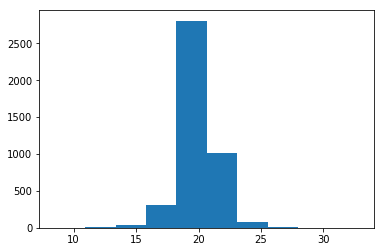

In [97]:
plt.hist(y_t)

(array([   2.,    3.,    4.,   18.,   90.,  376., 1214.,  310.,   62.,
          17.]),
 array([10.17     , 11.7040002, 13.2380004, 14.7720006, 16.3060008,
        17.840001 , 19.3740012, 20.9080014, 22.4420016, 23.9760018,
        25.510002 ]),
 <a list of 10 Patch objects>)

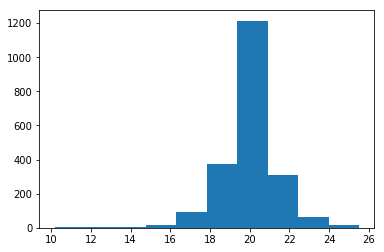

In [98]:
plt.hist(y_v)

In [59]:
# # Set up the model: model
# model = Sequential()

# # Add layer
# model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
# model.add(Dense(80, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(24, activation='relu'))
# model.add(Dense(12, activation='relu'))
# # Add the output layer
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam',loss='mean_absolute_error')
# # Verify that model contains information from compiling
# print("Loss function: " + model.loss)
# # Fit the model
# model.fit(X_train_std,y_train, epochs=150, verbose=False, batch_size=10)

# playground

In [56]:
# X_1, X_2, y_1, y_2 = train_test_split(X_train, y_train, test_size=0.5,random_state=42)

# y_p1 = grid.best_estimator_.predict(X_1)
# r2_score(y_1,y_p1)

# y_p2 = grid.best_estimator_.predict(X_2)
# r2_score(y_2,y_p2)